## Title 
Pre-Class Notebook

## Description :
This notebook is from CS109A. You can run it on Ed. If you choose to download, make sure you download the `Heart-2.csv` file as well.

This is material you should be familiar with. It is provided here as a review.

In [2]:
%matplotlib inline
import sys
import numpy as np
import pylab as pl
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import sklearn.metrics as met


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

# PCA

## Part 0: Reading the data 

In this notebook, we will be using the same Heart dataset from last lecture.  As a reminder the variables we will be using today include:

- `AHD`: whether or not the patient presents atherosclerotic heart disease (a heart attack): `Yes` or `No`
- `Sex`: a binary indicator for whether the patient is male (Sex=1) or female (Sex=0)
- `Age`: age of patient, in years
- `MaxHR`: the maximum heart rate of patient based on exercise testing
- `RestBP`: the resting systolic blood pressure of the patient
- `Chol`: the HDL cholesterol level of the patient
- `Oldpeak`: ST depression induced by exercise relative to rest (on an ECG)
- `Slope`: the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
- `Ca`: number of major vessels (0-3) colored by flourosopy

For further information on the dataset, please see the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

In [3]:
df_heart = pd.read_csv('../data/Heart-2.csv')

# Force the response into a binary indicator:
df_heart['AHD'] = 1*(df_heart['AHD'] == "Yes")

print(df_heart.shape)
df_heart.head()

(303, 15)


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,0
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,1
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,1
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,0
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,0


Here are some basic summaries and EDA we've seen before:

---

## Part 1: Principal Components Analysis (PCA) 

**Q1.1** Just a sidebar (and a curiosity), what happens when two of the identical predictor is used in logistic regression?  Is an error created?  Should one be?  Investigate by predicting `AHD` from two copies of `Age`, and compare to the simple logistic regression model with `Age` alone.

In [4]:
y = df_heart['AHD']

logit1 = LogisticRegression(solver="lbfgs").fit(df_heart[['Age']],y)

# investigating what happens when two identical predictors of 'Age' are used
logit2 = LogisticRegression(solver="lbfgs").fit(df_heart[['Age','Age']],y)

print("The coef estimate for Age (when in the model once):",logit1.coef_)
print("The coef estimates for Age (when in the model twice):",logit2.coef_)

The coef estimate for Age (when in the model once): [[0.05197647]]
The coef estimates for Age (when in the model twice): [[0.02599074 0.02599074]]


*your answer here*
    
The single coefficient for `Age` is distributed equally across the two predictors.  This is a very reasonable approach as predictions will still be stable.

We will apply PCA to the heart dataset when there are just 4 predictors considered (remember: PCA is used when dimensionality is high (lots of predictors), but this will help us get our heads around what is going on):

In [5]:
# For pedagogical purposes, let's simplify our lives and use just 7 predictors
X = df_heart[['Age','RestBP','Chol','MaxHR','Sex','Oldpeak','Slope']]
y = df_heart['AHD']
X.describe()

,Age,RestBP,Chol,MaxHR,Sex,Oldpeak,Slope
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,0.679868,1.039604,1.600660
std,9.038662,17.599748,51.776918,22.875003,0.467299,1.161075,0.616226
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,1.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000,1.000000
50%,56.000000,130.000000,241.000000,153.000000,1.000000,0.800000,2.000000
75%,61.000000,140.000000,275.000000,166.000000,1.000000,1.600000,2.000000
max,77.000000,200.000000,564.000000,202.000000,1.000000,6.200000,3.000000


In [6]:
# Here is the table of correlations between our predictors.  This will be useful later on
X.corr()

,Age,RestBP,Chol,MaxHR,Sex,Oldpeak,Slope
Age,1.000000,0.284946,0.208950,-0.393806,-0.097542,0.203805,0.161770
RestBP,0.284946,1.000000,0.130120,-0.045351,-0.064456,0.189171,0.117382
Chol,0.208950,0.130120,1.000000,-0.003432,-0.199915,0.046564,-0.004062
MaxHR,-0.393806,-0.045351,-0.003432,1.000000,-0.048663,-0.343085,-0.385601
Sex,-0.097542,-0.064456,-0.199915,-0.048663,1.000000,0.102173,0.037533
Oldpeak,0.203805,0.189171,0.046564,-0.343085,0.102173,1.000000,0.577537
Slope,0.161770,0.117382,-0.004062,-0.385601,0.037533,0.577537,1.000000


**Q1.2** Is there any evidence of multicollinearity in the set of predictors?  How do you know?  How will PCA handle these correlations?

In [7]:
logit3 = LogisticRegression(solver='lbfgs', max_iter=140).fit(X,y)
col_names = X.columns.tolist()
pred_coef = pd.DataFrame(col_names,logit3.coef_[0])

print(pred_coef)

                 0
 0.010806      Age
 0.014900   RestBP
 0.006536     Chol
-0.035433    MaxHR
 1.552654      Sex
 0.550020  Oldpeak
 0.283085    Slope


**Solution:**

Yes, there is evidence of collinearity as the estimated $\beta$ coefficient for `Age` changes greatly from the simple regression model ($\hat{\beta} = 0.0520$) to this multiple regression model ($\hat{\beta} = 0.00525$): a 10-fold decrease.

Next we apply the [PCA transformation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) in a few steps, and show some of the results below:

In [8]:
# create/fit the 'full' pca transformation
pca = PCA().fit(X)


In [9]:
pca.components_.shape


(7, 7)

In [10]:

cmp_round = np.round(pca.components_, 4)
cmp_df = pd.DataFrame(cmp_round, index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7'],columns=X.columns.values)

print(cmp_df)

        Age  RestBP    Chol   MaxHR     Sex  Oldpeak   Slope
PC1  0.0384  0.0505  0.9980 -0.0037 -0.0018   0.0012 -0.0000
PC2 -0.1806 -0.1050  0.0159  0.9776 -0.0008  -0.0179 -0.0104
PC3  0.1273  0.9818 -0.0541  0.1301 -0.0012   0.0089  0.0022
PC4  0.9745 -0.1497 -0.0293  0.1644 -0.0046  -0.0013 -0.0035
PC5 -0.0023 -0.0115 -0.0003  0.0191  0.0526   0.9483  0.3122
PC6 -0.0005 -0.0007 -0.0006  0.0037 -0.5027  -0.2451  0.8290
PC7  0.0051  0.0009  0.0016  0.0030  0.8629  -0.2006  0.4639


In [11]:

# here are the weighting (eigen-vectors) of the variables (first 2 at least)
print("First PCA Component (w1):",np.round(pca.components_[0],4))
print("Second PCA Component (w2):",np.round(pca.components_[1],4))

# here is the variance explained:
print("Variance explained by each component:",pca.explained_variance_ratio_)

First PCA Component (w1): [ 0.0384  0.0505  0.998  -0.0037 -0.0018  0.0012 -0.    ]
Second PCA Component (w2): [-1.806e-01 -1.050e-01  1.590e-02  9.776e-01 -8.000e-04 -1.790e-02
 -1.040e-02]
Variance explained by each component: [7.47915963e-01 1.50222918e-01 8.52586952e-02 1.61372448e-02
 3.47699826e-04 6.25312302e-05 5.49481983e-05]


In [12]:

# apply the pca transformation to the full predictor set
pcaX = pca.transform(X)

# convert to a data frame
pcaX_df = pd.DataFrame(pcaX, columns=[['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7']])


In [13]:
print(pcaX_df)

           PCA1       PCA2       PCA3       PCA4      PCA5      PCA6      PCA7
0    -12.665548  -2.815828  14.962801   6.807667  1.486887  0.685835  0.708260
1     41.294163 -45.302190  21.861167   0.007442 -0.581315 -0.146239  0.394792
2    -17.686479 -21.500671 -11.586630  11.118084  1.337828 -0.277307  0.112410
3      2.407571  39.875266   0.830064 -10.702279  3.559752  0.543622  0.458936
4    -43.290268  23.814879   1.853587  -7.906603  0.607573 -0.129404 -1.007264
..          ...        ...        ...        ...       ...       ...       ...
298   15.880451 -12.961311 -25.719774  -9.354867  0.224584  0.075085  0.335000
299  -52.408163 -13.059205  15.617388  11.525439  2.056244 -0.425860 -0.041361
300 -115.316903 -35.968713   0.423210   0.449460 -0.323723  0.065708  0.154984
301  -10.749665  23.405418   2.410131   7.074512 -0.415027  1.024822 -0.124070
302  -71.950294  24.055882  11.010056 -11.016245 -0.726006 -0.273245  0.085851

[303 rows x 7 columns]


**Q1.3** Now try the PCA decompositon on the standardized version of X instead.

In [14]:
### edTest(test_pcaZ) ###

# create/fit the standardized version of X
Z = sk.preprocessing.StandardScaler().fit(X).transform(X)

# create/fit the 'full' pca transformation on Z
pca_standard = PCA().fit(Z)
pcaZ = pca_standard.transform(Z)

# convert to a data frame
pcaZ_df = pd.DataFrame(pcaZ, columns=[['PCA-Z1','PCA-Z2','PCA-Z3','PCA-Z4','PCA-Z5','PCA-Z6','PCA-Z7']])


In [15]:
# Let's look at them to see what they are comprised of:
pd.DataFrame.from_dict({'Variable': X.columns,
                        'PCA1': pca.components_[0],
                        'PCA2': pca.components_[1],
                        'PCA-Z1': pca_standard.components_[0],
                        'PCA-Z2': pca_standard.components_[1]})

,Variable,PCA1,PCA2,PCA-Z1,PCA-Z2
0,Age,0.038401,-0.180599,0.411736,0.353496
1,RestBP,0.050464,-0.105023,0.269612,0.344915
2,Chol,0.997978,0.015946,0.123722,0.570322
3,MaxHR,-0.003744,0.977584,-0.473658,0.121837
4,Sex,-0.001809,-0.000845,0.010681,-0.546336
5,Oldpeak,0.001155,-0.017919,0.515666,-0.221566
6,Slope,-0.000004,-0.010406,0.502094,-0.261511


**Q2.3** Interpret the results above.  What does $w_1$ represent based on the untransformed data?  What doss $w_1$ represent based on the standardized data?  Which is a better representation of the data?

*your answer here*

$w_1$ represents the transformation (change in basis) to convert the columns of $\mathbf{X}$ to the first PCA vector, $z_1$.  They elements after quaring sum up to 1, so the magnitude represents euclidean weighting in the transformation (the larger value means more weight in the transformation).  

In [16]:
np.sum(pca.components_[0,:]**2)

np.float64(1.0000000000000002)

It is common for a model with high dimensional data (lots of predictors) to be plotted along the first 2 PCA components (with the classification boundaries added).  Below is the scatter plot for these data (without a classificaiton boundary, since we do not have a model yet):

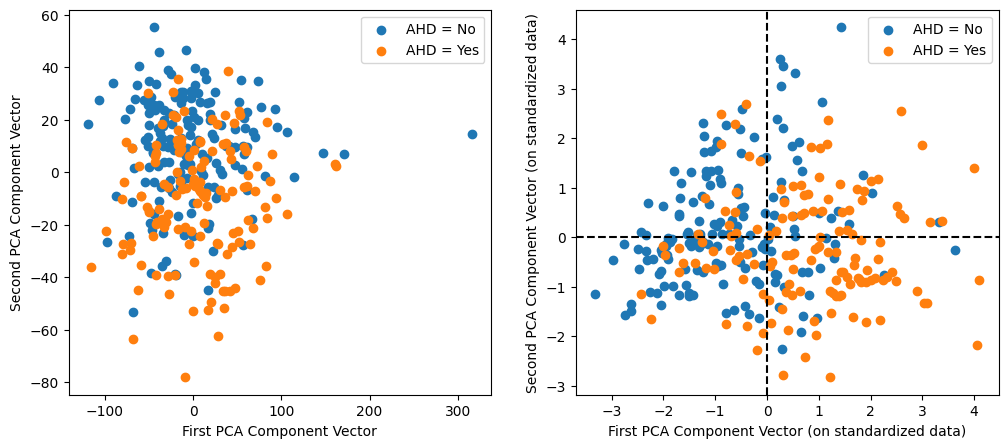

In [17]:
# Plot the response over the first 2 PCA component vectors

fig,(ax1,ax2) =  plt.subplots(1, 2, figsize = (12,5))

ax1.scatter(pcaX_df[['PCA1']][y==0],pcaX_df[['PCA2']][y==0])
ax1.scatter(pcaX_df[['PCA1']][y==1],pcaX_df[['PCA2']][y==1])
ax1.legend(["AHD = No","AHD = Yes"])
ax1.set_xlabel("First PCA Component Vector")
ax1.set_ylabel("Second PCA Component Vector");

ax2.scatter(pcaZ_df[['PCA-Z1']][y==0],pcaZ_df[['PCA-Z2']][y==0])
ax2.scatter(pcaZ_df[['PCA-Z1']][y==1],pcaZ_df[['PCA-Z2']][y==1])
# draw horizontal and vertical sepatation lines at 0 for each PC
ax2.axhline(y=0, color='black', linestyle='--')
ax2.axvline(x=0, color='black', linestyle='--')
ax2.legend(["AHD = No","AHD = Yes"])
ax2.set_xlabel("First PCA Component Vector (on standardized data)")
ax2.set_ylabel("Second PCA Component Vector (on standardized data)");


**Q2.4** Does there appear to be good potential here?  Which form of the data appear to provide better information as to *seperate* the classes in the response?  What would a classification boundary look like if a logistic regression model were fit using the first 2 principal components as the predictors?  

*your answer here*

It would again be linear.  Here, most likely the boundary would be a line with negative or (positive?) slope.

## Part 2: PCA in Regression (PCR) 

First let's fit the full logistic regression model to predict `AHD` from the 7 predictors above.

Remember: PCA is an approach to handling the predictors (unsupervised), so it does not matter if we are using it for a regression or classification type problem.

In [ ]:
#fit the 'full' model on the 7 predictors. and print out the coefficients
logit_full = LogisticRegression(penalty=None,solver="lbfgs",max_iter=2000).fit(X,y)

beta = logit_full.coef_[0]

print(beta)

/home/jules/Training/Playground/.venv/lib64/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


[ 0.01196012  0.01540104  0.00698381 -0.03596138  1.74077482  0.55632638
  0.30014592]


Below is the result of the PCR-1 (logistic) to predict `AHD` from the first principal component vector.

In [25]:
logit_pcr1 = LogisticRegression(solver="lbfgs").fit(pcaX_df[['PCA1']],y)

print("Intercept from simple PCR-Logistic:",logit_pcr1.intercept_)
print("'Slope' from simple PCR-Logistic:", logit_pcr1.coef_)

print("First PCA Component (w1):",pca.components_[0])


Intercept from simple PCR-Logistic: [-0.16620987]
'Slope' from simple PCR-Logistic: [[0.00351118]]
First PCA Component (w1): [ 3.84007875e-02  5.04636205e-02  9.97978046e-01 -3.74374033e-03
 -1.80930152e-03  1.15452228e-03 -3.60044587e-06]


**Q2.1** What does this PCR-1 model tell us about how the predictors relate to the response (aka, estimate the coefficient(s) in the original predictor space)?  Is it truly a simple logistic regression model in the original predictor space?

In [26]:
# your code here: do a multiplication of pcr_1's coefficients times the first component vector from PCA

(logit_pcr1.coef_*pca.components_[0])

array([[ 1.34831934e-04,  1.77186668e-04,  3.50407685e-03,
        -1.31449322e-05, -6.35277658e-06,  4.05373125e-06,
        -1.26418002e-08]])

*your answer here*

The estimated slope from PCR1 ( $\hat{\beta}= 0.00351092$) is distributed across the 4 actual predictors, so that the formula would be:

$$\hat{y} = 0.00351(Z_1) =  0.00351(w^T_1\mathbf{X}) =  0.00351(0.0384X_1+0.0505X_2+0.998X_3-0.0037X_4) \\ = 0.000135X_1+0.000177X_2+0.00350X_3-0.0000131X_4) $$

This is how to interpret the estimated coefficients from a regression with PCA components as the predictors: some transformation back to the original space is required.

Here is the above claculation for a few up to the 7th PCR logistic regression, and then plotted on a 'pretty' plot:

In [27]:
# Fit the other 3 PCRs on the rest of the 7 predictors
#pcaX_df.iloc[:,np.arange(0,5)].head()

logit_pcr2 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1','PCA2']],y)
logit_pcr3 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1','PCA2','PCA3']],y)
logit_pcr4 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1','PCA2','PCA3','PCA4']],y)
logit_pcr5 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1','PCA2','PCA3','PCA4','PCA5']],y)
logit_pcr6 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df[['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6']],y)
logit_pcr7 = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaX_df,y)

pcr1=(logit_pcr1.coef_*np.transpose(pca.components_[0:1,:])).sum(axis=1)
pcr2=(logit_pcr2.coef_*np.transpose(pca.components_[0:2,:])).sum(axis=1)
pcr3=(logit_pcr3.coef_*np.transpose(pca.components_[0:3,:])).sum(axis=1)
pcr4=(logit_pcr4.coef_*np.transpose(pca.components_[0:4,:])).sum(axis=1)
pcr5=(logit_pcr5.coef_*np.transpose(pca.components_[0:5,:])).sum(axis=1)
pcr6=(logit_pcr6.coef_*np.transpose(pca.components_[0:6,:])).sum(axis=1)
pcr7=(logit_pcr7.coef_*np.transpose(pca.components_[0:7,:])).sum(axis=1)

results = np.vstack((pcr1,pcr2,pcr3,pcr4,pcr5,pcr6,pcr7,beta))
print(results)

[[ 1.34831934e-04  1.77186668e-04  3.50407685e-03 -1.31449322e-05
  -6.35277658e-06  4.05373125e-06 -1.26418002e-08]
 [ 8.22888139e-03  4.90460029e-03  3.52035681e-03 -4.36772643e-02
   3.00832874e-05  8.05215560e-04  4.64728134e-04]
 [ 9.67824240e-03  1.57233392e-02  2.98485772e-03 -4.25087725e-02
   1.66252722e-05  9.08357132e-04  4.91470257e-04]
 [ 4.87937328e-03  1.65220860e-02  3.12832994e-03 -4.33112238e-02
   3.92241495e-05  9.15507194e-04  5.08938426e-04]
 [ 1.97160112e-03  1.21592916e-02  3.37846293e-03 -3.28220970e-02
   3.64476979e-02  6.57141425e-01  2.16558303e-01]
 [ 1.76358672e-03  1.28415843e-02  3.91515583e-03 -3.62052066e-02
   3.73983959e-01  8.31597035e-01 -3.35837985e-01]
 [ 1.19579420e-02  1.54016222e-02  6.98377240e-03 -3.59618988e-02
   1.74069448e+00  5.56349539e-01  3.00124649e-01]
 [ 1.19601182e-02  1.54010370e-02  6.98380957e-03 -3.59613782e-02
   1.74077482e+00  5.56326377e-01  3.00145919e-01]]


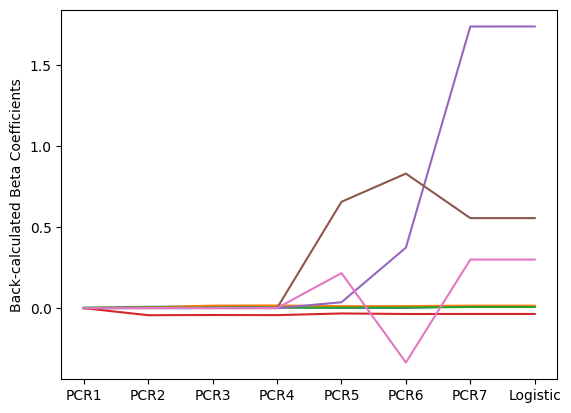

In [28]:
plt.plot(['PCR1','PCR2', 'PCR3', 'PCR4','PCR5','PCR6','PCR7', 'Logistic'],results)

plt.ylabel("Back-calculated Beta Coefficients");

#plt.legend(X.columns);

**Q2.5** Interpret the plot above.  Specifically, compare how each PCA vector "contributes" to the original logistic regression model using all 7 original predictors.  How Does PCR-4 compare to the original logistic regression model (in estimated coefficients)?

*your answer here*

This plot shows that as more PCA vectors are included in the PCA-Regression, the estimated $\beta$s from the original regression model are recovered: if PCR($p$) is used (where $p$ is the number of predictors we started with), they are mathemtaically equivalent.  

All of this PCA work should have been done using the standardized versions of the predictors.  Below is the code that does exactly that:

In [32]:
scaler = sk.preprocessing.StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)
pca = PCA(n_components=7).fit(Z)
pcaZ = pca.transform(Z)
pcaZ_df = pd.DataFrame(pcaZ, columns=[['PCA1' , 'PCA2', 'PCA3', 'PCA4','PCA5', 'PCA6', 'PCA7']])

print("First PCA Component (w1):",pca.components_[0])
print("Second PCA Component (w2):",pca.components_[1])

First PCA Component (w1): [ 0.41173599  0.26961154  0.12372188 -0.47365763  0.01068056  0.51566635
  0.50209418]
Second PCA Component (w2): [ 0.35349616  0.34491485  0.57032206  0.121837   -0.54633621 -0.22156592
 -0.26151097]


In [33]:
#fit the 'full' model on the 7 predictors. and print out the coefficients
logit_full = LogisticRegression(C=1000000,solver="lbfgs").fit(Z,y)


betaZ = logit_full.coef_[0]

print("Logistic coef. on standardized predictors:",betaZ)

Logistic coef. on standardized predictors: [ 0.10813441  0.27088319  0.36135211 -0.82151466  0.81254141  0.64421284
  0.18522453]


[[ 0.36018987  0.23585829  0.10823287 -0.41435941  0.00934344  0.45110897
   0.43923593]
 [ 0.23486177  0.11213621 -0.09984489 -0.46424718  0.21007465  0.53807396
   0.54072123]
 [ 0.25056186  0.32042838 -0.141635   -0.38878498  0.34368974  0.56129402
   0.51294622]
 [ 0.36662601  0.29023376 -0.18498403 -0.48910018  0.40605021  0.48195047
   0.4328723 ]
 [ 0.10813441  0.27088319  0.36135211 -0.82151466  0.81254141  0.64421284
   0.18522453]
 [ 0.10813441  0.27088319  0.36135211 -0.82151466  0.81254141  0.64421284
   0.18522453]]


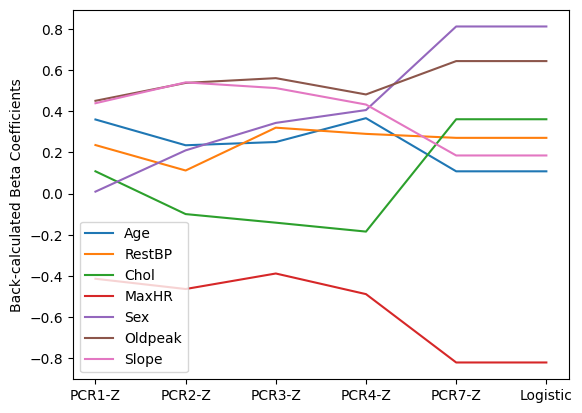

In [34]:
# Fit the PCR
logit_pcr1Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df[['PCA1']],y)
logit_pcr2Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df[['PCA1','PCA2']],y)
logit_pcr3Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df[['PCA1','PCA2','PCA3']],y)
logit_pcr4Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df[['PCA1','PCA2','PCA3','PCA4']],y)
logit_pcr7Z = LogisticRegression(C=1000000,solver="lbfgs").fit(pcaZ_df,y)

pcr1Z=(logit_pcr1Z.coef_*np.transpose(pca.components_[0:1,:])).sum(axis=1)
pcr2Z=(logit_pcr2Z.coef_*np.transpose(pca.components_[0:2,:])).sum(axis=1)
pcr3Z=(logit_pcr3Z.coef_*np.transpose(pca.components_[0:3,:])).sum(axis=1)
pcr4Z=(logit_pcr4Z.coef_*np.transpose(pca.components_[0:4,:])).sum(axis=1)
pcr7Z=(logit_pcr7Z.coef_*np.transpose(pca.components_)).sum(axis=1)

resultsZ = np.vstack((pcr1Z,pcr2Z,pcr3Z,pcr4Z,pcr7Z,betaZ))
print(resultsZ)

plt.plot(['PCR1-Z' , 'PCR2-Z', 'PCR3-Z', 'PCR4-Z', 'PCR7-Z', 'Logistic'],resultsZ)

plt.ylabel("Back-calculated Beta Coefficients");

plt.legend(X.columns);

**Q2.6** Compare this plot to the previous one; why does this plot make sense?.  What does this illustrate?  

**Solution:**

This plot shows that the components are now more evenly composed of the predictors, rather than the first component being dominated by the predictor with the most variability.  The 4 lines move more similarly here than in the previous plot where they essentially moved one predictor for one component.